# Определение возраста покупателей

## Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.  

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.  

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(250, 250),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels['real_age'].value_counts()

30     317
25     315
27     229
26     226
28     217
      ... 
96       2
100      1
93       1
91       1
97       1
Name: real_age, Length: 97, dtype: int64

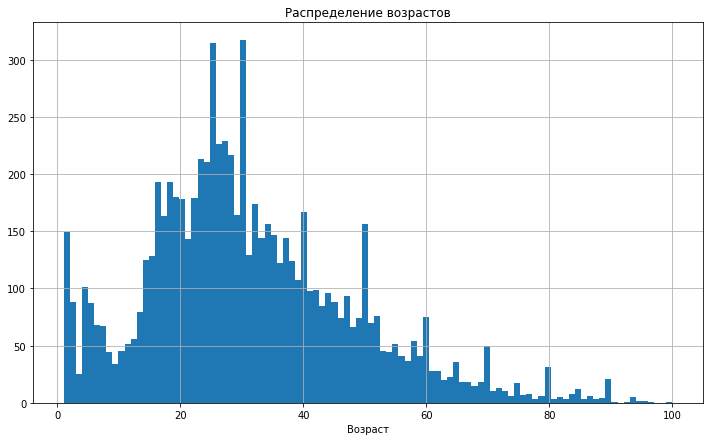

In [5]:
plt.figure(figsize=(12,7))
plt.title('Распределение возрастов')
plt.xlabel('Возраст')
labels['real_age'].hist(bins=100)

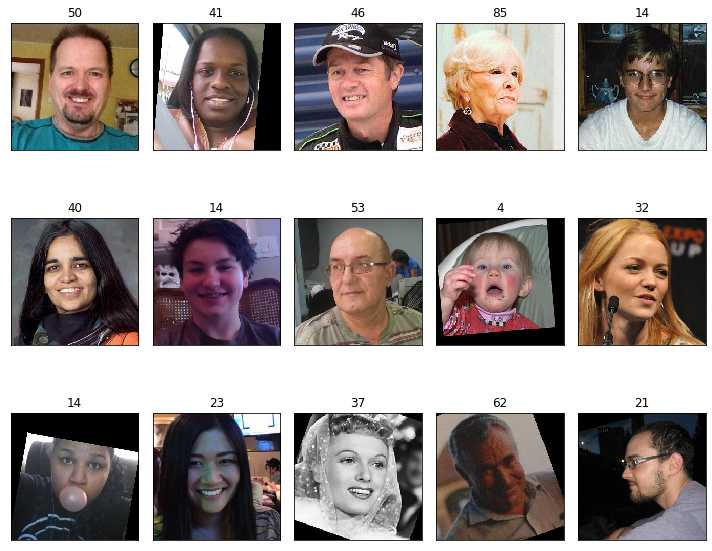

In [6]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод
* Всего 7591 объектов в датасете
* Большинство людей в выборке находятся в возрасте от 18 до 30 лет, есть риск того, что модель будет плохо отрабатывать на людях в возрасте 65+
* В исходных данных есть перевернутые, чб фото, а также снимки людей в очках и в профиль

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, horizontal_flip_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(250, 250),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(250, 250),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr = 0.00025)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```
Train for 190 steps, validate for 48 steps
Epoch 1/20
2021-07-04 13:00:51.710508: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-07-04 13:00:52.007265: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 48s - loss: 253.6315 - mae: 11.6589 - val_loss: 547.1461 - val_mae: 18.2215
Epoch 2/20
190/190 - 39s - loss: 110.6462 - mae: 8.0378 - val_loss: 375.7760 - val_mae: 14.4120
Epoch 3/20
190/190 - 40s - loss: 89.9478 - mae: 7.1946 - val_loss: 377.0334 - val_mae: 14.5352
Epoch 4/20
190/190 - 40s - loss: 71.2064 - mae: 6.4283 - val_loss: 123.4092 - val_mae: 8.3044
Epoch 5/20
190/190 - 39s - loss: 56.0788 - mae: 5.7046 - val_loss: 117.5976 - val_mae: 8.0957
Epoch 6/20
190/190 - 39s - loss: 45.1581 - mae: 5.1485 - val_loss: 126.0829 - val_mae: 8.4482
Epoch 7/20
190/190 - 39s - loss: 37.0305 - mae: 4.6197 - val_loss: 168.2940 - val_mae: 10.5235
Epoch 8/20
190/190 - 39s - loss: 29.9465 - mae: 4.1987 - val_loss: 77.1240 - val_mae: 6.5583
Epoch 9/20
190/190 - 39s - loss: 26.4224 - mae: 3.9595 - val_loss: 92.0428 - val_mae: 7.1626
Epoch 10/20
190/190 - 39s - loss: 23.6019 - mae: 3.7281 - val_loss: 81.2815 - val_mae: 6.8983
Epoch 11/20
190/190 - 39s - loss: 20.1034 - mae: 3.4457 - val_loss: 78.0212 - val_mae: 6.6981
Epoch 12/20
190/190 - 39s - loss: 16.6047 - mae: 3.1459 - val_loss: 82.8838 - val_mae: 6.9439
Epoch 13/20
190/190 - 39s - loss: 17.0144 - mae: 3.1279 - val_loss: 78.4625 - val_mae: 6.7812
Epoch 14/20
190/190 - 39s - loss: 15.8202 - mae: 3.0511 - val_loss: 92.2533 - val_mae: 7.3934
Epoch 15/20
190/190 - 39s - loss: 15.5373 - mae: 3.0192 - val_loss: 86.8140 - val_mae: 6.8750
Epoch 16/20
190/190 - 39s - loss: 13.2146 - mae: 2.7727 - val_loss: 80.6846 - val_mae: 6.6582
Epoch 17/20
190/190 - 39s - loss: 11.9908 - mae: 2.6552 - val_loss: 83.0681 - val_mae: 6.7598
Epoch 18/20
190/190 - 39s - loss: 10.3108 - mae: 2.4634 - val_loss: 86.1225 - val_mae: 7.0208
Epoch 19/20
190/190 - 39s - loss: 11.0822 - mae: 2.5058 - val_loss: 72.5585 - val_mae: 6.3380
Epoch 20/20
190/190 - 39s - loss: 10.7788 - mae: 2.5049 - val_loss: 78.4231 - val_mae: 6.5070
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 78.4231 - mae: 6.5070
Test MAE: 6.5070

```

### Выводы
* Обучили свёрточную нейронную сеть с архитектурой ResNet50
* Получили хороший результат. Можно отметить склонность модели к переобучению и сократить число эпох до 10.
* Получили метрику качества МАЕ - 6.5.

## Анализ обученной модели

* Всего 7591 объектов в датасете
* Данные распределены не равномерно: большинство людей в выборке находятся в возрасте от 20 до 30 лет, есть риск того, что модель будет допускать бОльшие ошибки на людях старше 65, но лучше справляться с возрастом 18-30 
* В исходных данных есть перевернутые, чб фото, а также снимки людей в очках и в профиль
* Обучили свёрточную нейронную сеть с архитектурой ResNet50
* Получили метрику качества МАЕ - 6.5, Нейронная сеть ошибается в среднем на 6.5 лет при прогнозе возраста по фото.   

Это дает возможность:   
* Проанализировав покупки, можно предлагать на кассе товары, которые могут заинтересовать покупателей нужной возрастной группы или предлагать персонализированные специальные предложения  
* Контролировать добросовестность кассиров при продаже алкоголя  